In [2]:
import torch
import torch.nn as nn

import torchvision.datasets as dset
import torchvision.transforms as T

In [3]:
### Variables

dataroot = "dataset"

image_size = 64

b_size = 128

workers = 2

ngpu = 1

nz = 100
nc = 3
ngf = 128
ndf = 128

num_epochs = 150

lr = 0.0002

In [9]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.CenterCrop(image_size),
                               T.ToTensor(),
                            #    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=b_size,
                                         shuffle=True, num_workers=workers)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cpu')

In [ ]:
from torch.nn.modules.activation import LeakyReLU
class G(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4,1,0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
        
            # nn.ConvTranspose2d(ngf*16, ngf*8, 4,2,1, bias=False),
            # nn.BatchNorm2d(ngf*8),
            # nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4,2,1, bias=False),
            nn.Tanh()
        )

    def forward(self,x):
        return self.main(x)

class D(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf, ndf*2, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),

            # nn.Conv2d(ndf*8, ndf*16, 4,2,1, bias=False),
            # nn.BatchNorm2d(ndf*16),
            # nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*8, 1, 4,1,0, bias=False),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.main(x)

In [5]:
transform = T.ToPILImage()

[0/150] [0/55], Loss:0.11413174867630005, LossG:11.91862678527832, D(x):0.965776264667511
[0/150] [10/55], Loss:0.21985593438148499, LossG:4.459323883056641, D(x):0.8286019563674927
[0/150] [20/55], Loss:0.08706571906805038, LossG:6.145147800445557, D(x):0.9981462359428406
[0/150] [30/55], Loss:0.06863245368003845, LossG:5.90238094329834, D(x):0.968693733215332
[0/150] [40/55], Loss:0.08240728080272675, LossG:6.039005279541016, D(x):0.979606032371521
[0/150] [50/55], Loss:0.01920381560921669, LossG:6.577986240386963, D(x):0.9827655553817749


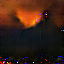

In [27]:
# netG = G().to(device)
# netD = D().to(device)

criterion = nn.BCELoss()

optimG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(.5,.999))
optimD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(.5,.999))

for epoch in range(1):
# while True:
    for i,data in enumerate(dataloader):
        netD.zero_grad()
        real = data[0].to(device)

        label = torch.full((b_size,),1, dtype=torch.float, device=device)

        output = netD(real).view(-1)
        lossR = criterion(output,label)
        lossR.backward()

        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)

        output = netD(fake.detach()).view(-1)

        lossF = criterion(output,label)
        lossF.backward()

        loss = lossR + lossF
        optimD.step()

        netG.zero_grad()
        label.fill_(1)

        output = netD(fake).view(-1)

        lossG = criterion(output,label).clone()
        lossG.backward(retain_graph=True)

        optimG.step()

        if i > 50:
            break

        if i % 10 == 0:
            print(f'[{epoch}/{num_epochs}] [{i}/{len(dataloader)}], Loss:{loss}, LossG:{lossG}, D(x):{D_x}')
    if epoch % 2 == 0:
        display(transform(fake[0]))
    epoch+=1

In [16]:
from PIL import Image

In [ ]:
transform = T.ToPILImage()

noise = torch.randn(1,100,1,1,device=device)

imgT = netG(noise)

display(transform(imgT[0]).resize((256,256),Image.ANTIALIAS))
display(transform(imgT[0]))


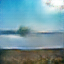

In [148]:
pic1 = imgT[0]
transform(pic1)

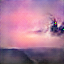

In [208]:
pic2 = imgT[0]
transform(pic2)

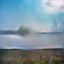

In [209]:
### Interpolating
n_steps = 30
images = []

for k in range(n_steps):
    lerp = torch.lerp(pic1,pic2,k/n_steps)
    images.append(lerp)

transform(images[5])

In [95]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()
frames = [[ax.imshow(images[i].cpu().permute(1,2,0).detach())] for i in range(len(images))]


anim = animation.ArtistAnimation(fig,frames)
HTML(anim.to_jshtml())

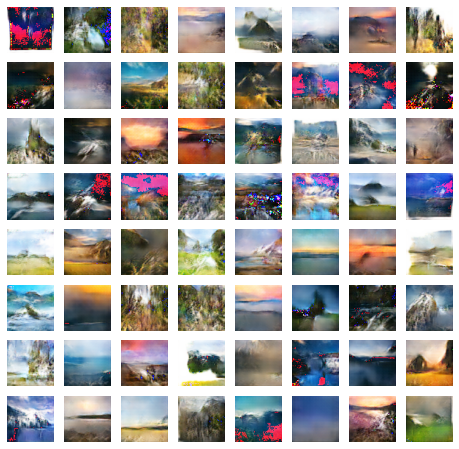

In [135]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
imgs = []

for j in range(64):
    noise = torch.randn(1,100,1,1,device=device)

    imgT = netG(noise)[0].cpu().permute(1,2,0).detach()

    plt.subplot(8,8,j+1)
    plt.axis("off")
    plt.imshow(np.array(imgT * 255).astype(np.uint8))

# plt.show()
plt.savefig("64imgs_3.png")

In [ ]:
### Save models
torch.save(netG,'GParams.pt')
torch.save(netD,'DParams.pt')

In [ ]:
### Load models
netG = torch.load('GParams.pt',map_location=device)
netD = torch.load('DParams.pt',map_location=device)
netG.eval()
netD.eval()